In [42]:
import pystan
import pylab as plt
import seaborn as sns
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns

# MindLab Model for shelving
There are three variables that could effect whether an item is selected, `product_index`, `product` and `price`. We want to be able to marginalise out product and price to see effect of shelf position (`product_index`). As there is a binary input from the user, we will use the bernoulli probability distribution as our likelihood function. The bernoulli distribution is a special case of the binomial distribution i.e. when n=1.


$$y_j\sim\mbox{bernoulli}\left( \mbox{logit}^{-1}(f(m_{\alpha_i},\beta_i,c_{\gamma_i}))\right),\mbox{ for } j=1,\dots, J.$$

* $y_{ij}$ is the response for person $j$ to a particular product ($m_{\alpha}$) at a particular price ($\beta_{i}$)   and location on shelf ($c_{i}$) i.e. `fit`=1 or `does not fit`=0
* $m_{\alpha} $ is product (discrete)
* $\beta_i$ is price (continuous)
* $c_{\gamma}$ is position (discrete)



The key is coming up with the function ($f$)

For this model, we will still assume a linear relationship between price and selection placement:
$$m_{1,\alpha_{i}}*\beta_{i,1}+m_{2,\alpha_{i}}*\beta_{i,2}+c_{\gamma_{i}}$$
where:
* $m_1$ is slope, telling us how much base price affects selection
* $m_2$ is slope telling us how much discounted price affects selection
* $c$ is intercept, telling us how much product position changes selection

However, we will now introduce a hierarchical element to the intercept, such that there is a global mean intercept for all positions. I will model this with a multi D Gaussian, such that correlations between the positions are also picked up.

## Build the model

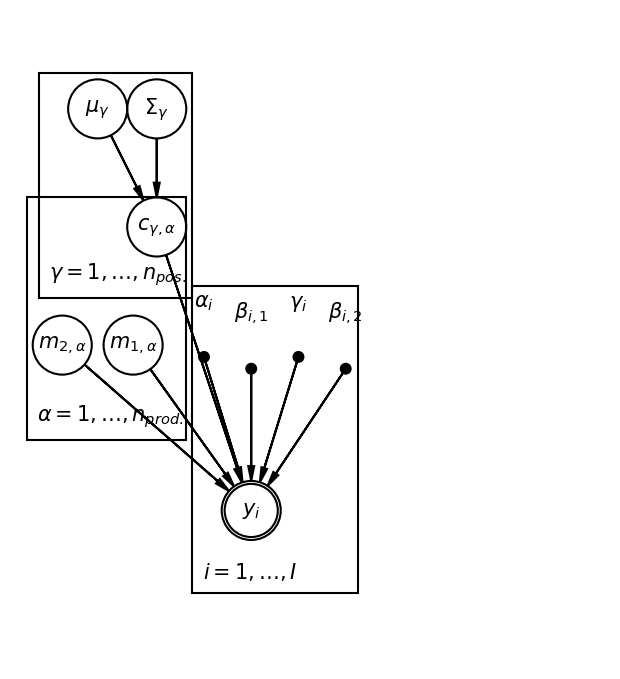

In [43]:
import daft

pgm = daft.PGM(shape=(5,5.5),observed_style="inner",dpi=150)

pgm.add_node('m1',r'$m_{1,\alpha}$',1,2.7)
pgm.add_node('m2',r'$m_{2,\alpha}$',0.4,2.7)

pgm.add_node('beta_1',r'$\beta_{i,1}$',2,2.5,fixed=True)
pgm.add_node('beta_2',r'$\beta_{i,2}$',2.8,2.5,fixed=True)

pgm.add_node('c',r'$c_{\gamma,\alpha}$',1.2,3.7)

pgm.add_node('y',r'$y_i$',2,1.3,observed=True)
pgm.add_node('alpha',r'$\alpha_i$',1.6,2.6,fixed=True)
pgm.add_node('gamma',r'$\gamma_i$',2.4,2.6,fixed=True)

#hierarchical elements
pgm.add_node('mu_c',r'$\mu_{\gamma}$',0.7,4.7)
pgm.add_node('sigma_c',r'$\Sigma_{\gamma}$',1.2,4.7)


pgm.add_edge('m1','y')
pgm.add_edge('m2','y')

pgm.add_edge('beta_1','y')
pgm.add_edge('beta_2','y')

pgm.add_edge('c','y')
pgm.add_edge('gamma','y')
pgm.add_edge('alpha','y')
pgm.add_edge('mu_c','c')
pgm.add_edge('sigma_c','c')



pgm.add_plate([1.5, 0.7, 1.4, 2.5], label=r"$i = 1, \ldots, I$", shift=-0.1)
pgm.add_plate([0.1, 2, 1.35, 1.95], label=r"$\alpha = 1, \ldots, n_{prod.}$", shift=-0.1)
pgm.add_plate([0.2, 3.2, 1.30, 1.8], label=r"$\gamma = 1, \ldots, n_{pos.}$", shift=-0.1)




# Render and save.
pgm.render()
pgm.show()

### Visualising how our model works

<IPython.core.display.Javascript object>


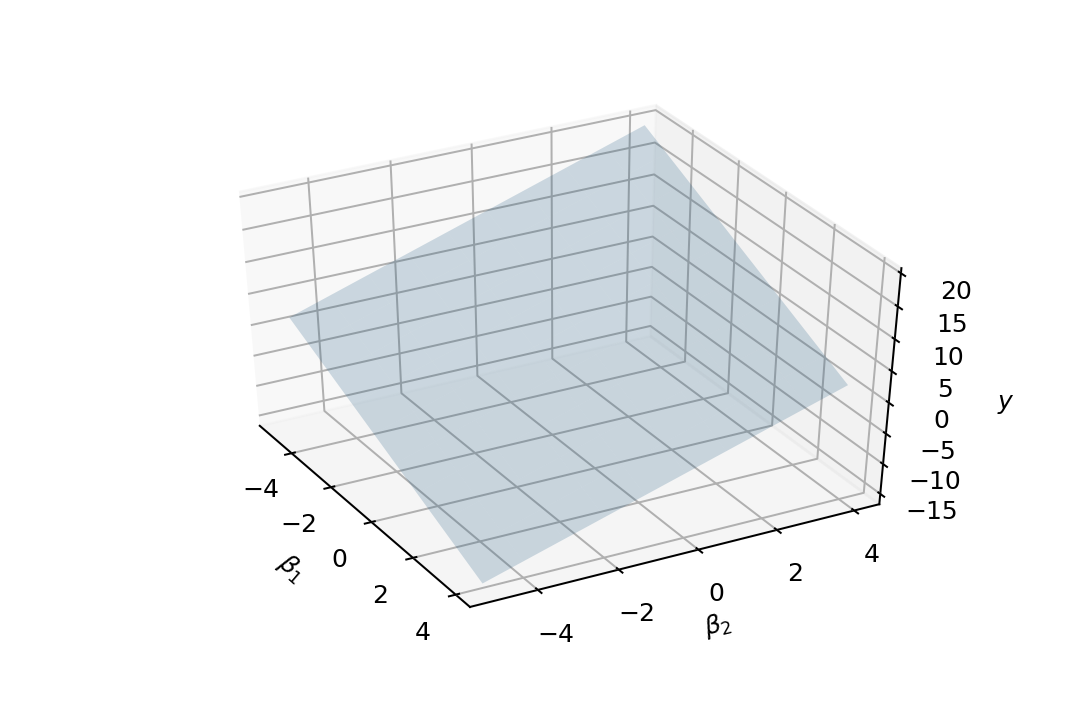

In [18]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook


m_1=-2
m_2=2
c=2
# create x,y
beta_1,beta_2= np.meshgrid(np.arange(-5,5),np.arange(-5,5))

# calculate corresponding y
y = m_1*beta_1+m_2*beta_2+c
# plot the surface
plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(beta_1, beta_2, y, alpha=0.2)
plt3d.set_xlabel(r'$\beta_1$');
plt3d.set_ylabel(r'$\beta_2$');
plt3d.set_zlabel(r'$y$');

In [19]:
#reset notebook ploting
%matplotlib inline


### Some Stan tips for hierarchical modelling

## Covariance matrices and Cholesky Factorization

Rather than model the hierarchical distribution of $c$ as an independent Gaussian i.e.:
$$\mathcal{N}(\mu_c,\sigma_c^2)$$

We want to model it with a full covariance matrix so that we can capture any correlations between positions, i.e. if one position is more liked then so is another. 
$$\mathcal{N}(\mu_c,\Sigma_c)$$
$\Sigma_c$ is the full $N_{positions}\times N_{positions}$ covariance matrix. Diagonal elements are the $\sigma_c^2$ as before, and off diagonal elements give the covariance e.g. $\sigma_{i,j}^2$.

When modelling in Stan, we could use the following code (using non-centred parameterisation like before):

    parameters{
    cov_matrix[K] Sigma;
    matrix [K,P] c_raw;
    }

    model{

    c_raw~normal(0,1);
    c=c_raw*Sigma+hier_c_mean;
    .....
    }
    

It can sometimes be more beneficial to specify the covariance matrix via its correlation matrix ($\Omega$) and scale matrix ($\tau$). e.g. 
$$\Sigma = \texttt{diag}\mathtt{\_}\texttt{matrix}(\tau) \times \Omega \times \texttt{diag}\mathtt{\_}\texttt{matrix}(\tau)$$
where
$$\tau_k = \sqrt{\Sigma_{k,k}}
\quad\textsf{and}\quad 
\Omega_{i, j} = \frac{\Sigma_{i, j}}{\tau_i \, \tau_j}$$


We can also put a LKJ prior on the correlation matrix. The LKJ prior has a parameter $\eta$ which governs how much correlation you think there should be. A $\eta$ of 1 gives equal weighting to all elements of the correlation matrix, $\eta>1$ favores less correlation and $\eta<1$ and favours more correlation.

We can also deploy another trick called Cholesky factorisation, which factorises a Hermitian, positive-definite matrix (which our correlation matrix is) into the product of a lower triangular matrix and its conjugate transpose, which is useful for efficient numerical solutions.


     parameters{
      vector[K] c_raw[P];      
      vector[K] hier_c_mean; 
      cholesky_factor_corr[K] L_Omega;
      vector<lower=0>[K] tau;      // prior scale
     }
  
    transformed parameters {
      vector[K] c[P];
      for (i in 1:P){
        c[i]=hier_c_mean + (diag_pre_multiply(tau,L_Omega) * c_raw[i]);//non centred param.
          }
    }

    model {
        c_raw[i] ~std_normal();
        hier_c_mean~normal(0,3);
        L_Omega ~ lkj_corr_cholesky(2); //LKJ prior
        tau ~ normal(0, 1); // prior on scale
       }
   

There is a lot more discussion on this in the [Stan manual section on multivariate-hierarchical-priors-section](https://mc-stan.org/docs/2_22/stan-users-guide/multivariate-hierarchical-priors-section.html)

#### Technical details of Cholesky decomposition
In order to solve for the lower triangular matrix, we will make use of the Cholesky-Banachiewicz Algorithm. First, we calculate the values for L on the main diagonal. Subsequently, we calculate the off-diagonals for the elements below the diagonal:

$$\begin{eqnarray*}
l_{kk} &=& \sqrt{ a_{kk} - \sum^{k-1}_{j=1} l^2_{kj}}\\
l_{ik} &=& \frac{1}{l_{kk}} \left( a_{ik} - \sum^{k-1}_{j=1} l_{ij} l_{kj} \right), i > k
\end{eqnarray*}$$

Numpy and Stan have this decomposition built in.

Lets just show it working in Python:



In [33]:
#specify covariance matrix
cov = np.array([[ 10.0, -2.00,  2.00], 
                [-2.00, 20.00,  0.50],
                [ 2.00,  0.50,  0.50]])
# get standard deviation
std_ = np.sqrt(np.diag(cov))

corr_empirical = cov / np.outer(std_, std_)


In [34]:
# carry out Cholelsky decomposition
L = np.linalg.cholesky(corr_empirical)

In [35]:
#generate uncorrelated samples
x_uncor = np.random.normal(0, 1, (3, 1000))

#### Uncorrelated distribution

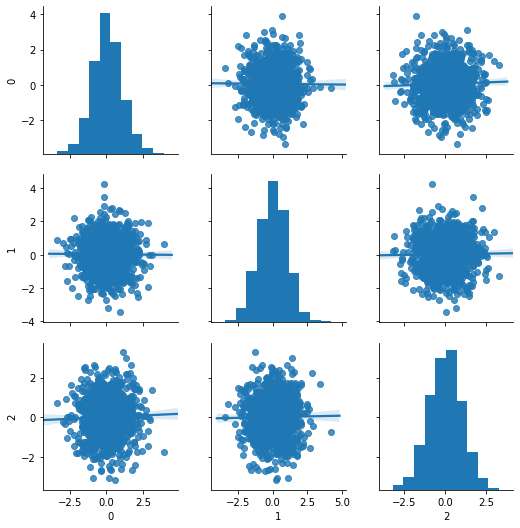

In [39]:
sns.pairplot(pd.DataFrame(x_uncor.T), kind="reg")

#### Cholesky factorisation version

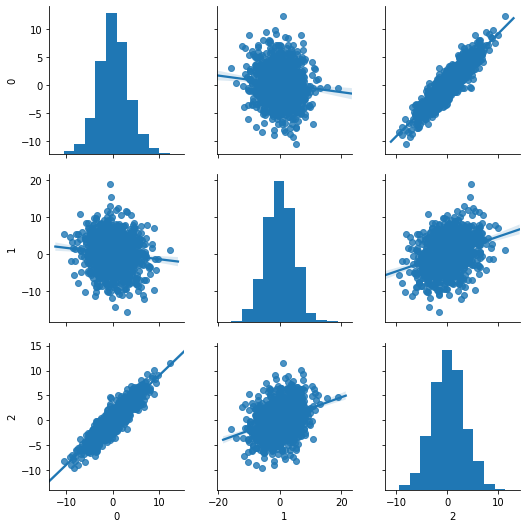

In [36]:
sns.pairplot(pd.DataFrame(np.dot(np.dot(L,np.diag(std_)),x_uncor).T), kind="reg")

#### Sampling straight from correlated matrix

In [29]:
#generate uncorrelated samples
x_cor = np.random.multivariate_normal(np.zeros(3), cov, size=1000)

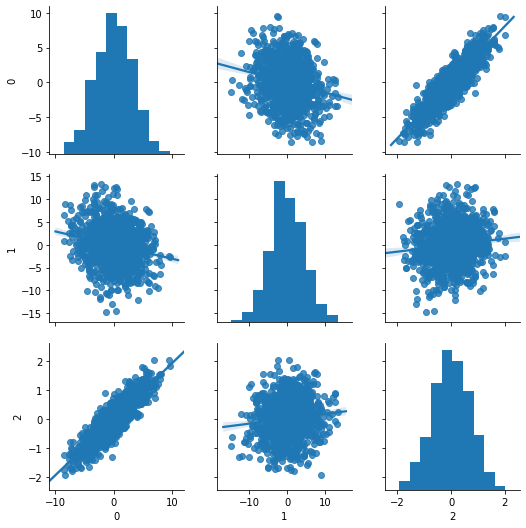

In [32]:
sns.pairplot(pd.DataFrame(x_cor), kind="reg")

In [47]:
model="""
data {
  int<lower=1> K;              // number of product places
  int<lower=1> N;              // number of observations
  vector[2] price[N];  //product price for observation n
  int<lower=1,upper=K> kk[N];  // product place for observation n
  int<lower=0,upper=1> y[N];   // selected or not for observation n
  int<lower=0> nprice; //number of price points
  int<lower=0> ndisc;  //number of discount prices
  real price_pred[nprice]; //price points for predictions
  real price_discount_pred[ndisc];
  int<lower=1> P; //number of products
  int<lower=1> product[N]; //product for observation n
  int fit; //boolean for fitting
}

parameters {
  vector[K] c_raw[P];              // effect of place for k
  row_vector[2] m[P]; // slope;
  vector[K] hier_c_mean; 
  cholesky_factor_corr[K] L_Omega;
  vector<lower=0>[K] tau;      // prior scale

  
  }

transformed parameters {
vector[K] c[P];

for (i in 1:P){
c[i]=hier_c_mean + (diag_pre_multiply(tau,L_Omega) * c_raw[i]);
}

}


model {
for (i in 1:P){
m[i] ~ std_normal();
c_raw[i] ~std_normal();
}
hier_c_mean~normal(0,3);
L_Omega ~ lkj_corr_cholesky(2);
tau ~ normal(0, 1);

  if (fit > 0){
  for (i in 1:N){
  y[i] ~ bernoulli_logit(m[product[i]]*price[i] + c[product[i],kk[i]]);
  }
  }
}

generated quantities {
vector[N] y_rep;
matrix[ndisc,nprice] pred_matrix[P,K];
matrix[ndisc,nprice] pred_matrix_select[P,K];
if (N<2)
for (i in 1:nprice){
for (d in 1:ndisc){
for (j in 1:K){
for (z in 1:P){
pred_matrix[z,j,d,i]=m[z,1]*price_pred[i] + m[z,2]*price_discount_pred[d]+c[z,j];
pred_matrix_select[z,j,d,i]=bernoulli_logit_rng(pred_matrix[z,j,d,i]);
}
}
}
}
if (fit > 0){
for (i in 1:N){
y_rep[i] = bernoulli_logit_rng(m[product[i]]*price[i] + c[product[i],kk[i]]);
}
}
}
"""

In [48]:
sm=pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d5143d238b9a83ee237930e79997035c NOW.


In [44]:
data={
    'K':5,
    'N':1,
    'price':np.array([[0],[0]]).T,
    'kk':[1],
    'y':[1],
    'nprice':10,
    'ndisc':9,
    'price_pred':np.arange(-5,5,1.0),
    'price_discount_pred':np.arange(-5.5,3,1.0),
    'P':8,
    'product':[1],
    'fit':0
}

In [45]:
fit=sm.sampling(data=data,chains=1,iter=500)

NameError: name 'sm' is not defined

In [28]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_d5143d238b9a83ee237930e79997035c.
1 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=250.

                  mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
c_raw[1,1]      8.6e-3    0.04   1.08   -2.5  -0.65    0.05    0.7   2.02    787    1.0
c_raw[2,1]       -0.04    0.05   1.13  -2.36  -0.72   -0.01   0.55    2.3    624    1.0
c_raw[3,1]        0.04    0.07   0.98   -2.0  -0.68    0.08   0.79   1.76    208    1.0
c_raw[4,1]        0.03    0.04   0.99  -1.89   -0.7    0.08   0.77   1.86    565    1.0
c_raw[5,1]        0.08    0.04   1.05  -1.99  -0.67     0.1   0.82   2.12    595    1.0
c_raw[6,1]       -0.04    0.04   1.13  -2.16   -0.9   -0.02   0.76   2.12    666    1.0
c_raw[7,1]       -0.01    0.03   0.99  -1.94  -0.67   -0.05    0.7   1.85    872    1.0
c_raw[8,1]     -7.7e-3    0.06   0.99  -2.11  -0.73    0.02   0.63   1.

In [30]:
pystan.diagnostics.check_hmc_diagnostics(fit,verbose=3)

INFO:pystan:No divergent transitions found.
INFO:pystan:No transitions that ended prematurely due to maximum tree depth limit
INFO:pystan:Chain 1: E-BFMI (= 0.881) equals or exceeds threshold of 0.2.
INFO:pystan:E-BFMI indicated no pathological behavior


{'n_eff': False,
 'Rhat': False,
 'divergence': True,
 'treedepth': True,
 'energy': True}

Prior predictive distribution

<Figure size 720x720 with 0 Axes>

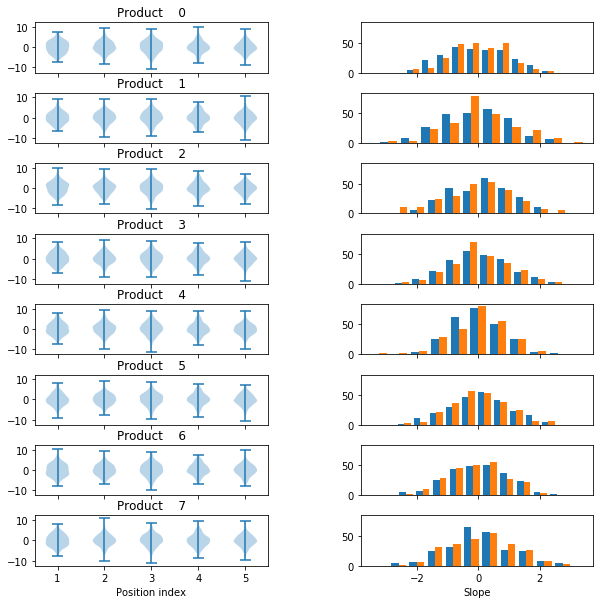

In [31]:
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(fit.data['P'], 2, sharex='col', sharey='col',figsize=(10,10))
for i in range(0,fit.data['P']):
    ax[i,0].violinplot(fit['c'][:,i,:]);
    ax[i,1].hist(fit['m'][:,i]);
    ax[i,0].set_title('Product {:4.0f}'.format(i))
ax[-1,0].set_xlabel('Position index')
ax[-1,1].set_xlabel('Slope')
fig.subplots_adjust(hspace=0.4, wspace=0.4)


The intercept and slopes for the different products. The first column shows the $c$ prior distribution for each product and the second column shows the prior disrtribution for slopes $m_1$ and $m_2$ for on sale price and pre discount price

### Prior Predictive distribuition
Lets visualise how the chances of selection change with price and prediscount price for some of the samples from our prior predicitive distribution.

The plot below shows a heatmap of price vs pre-discount price, where each column is a different product. The colours represent the chances of selection before applying the inverse logit transformation. Each row is a different sample from our prior, so can be thought of as different possible datasets.

Note how it is acting like our plane.

Which ones behave as you would expect??

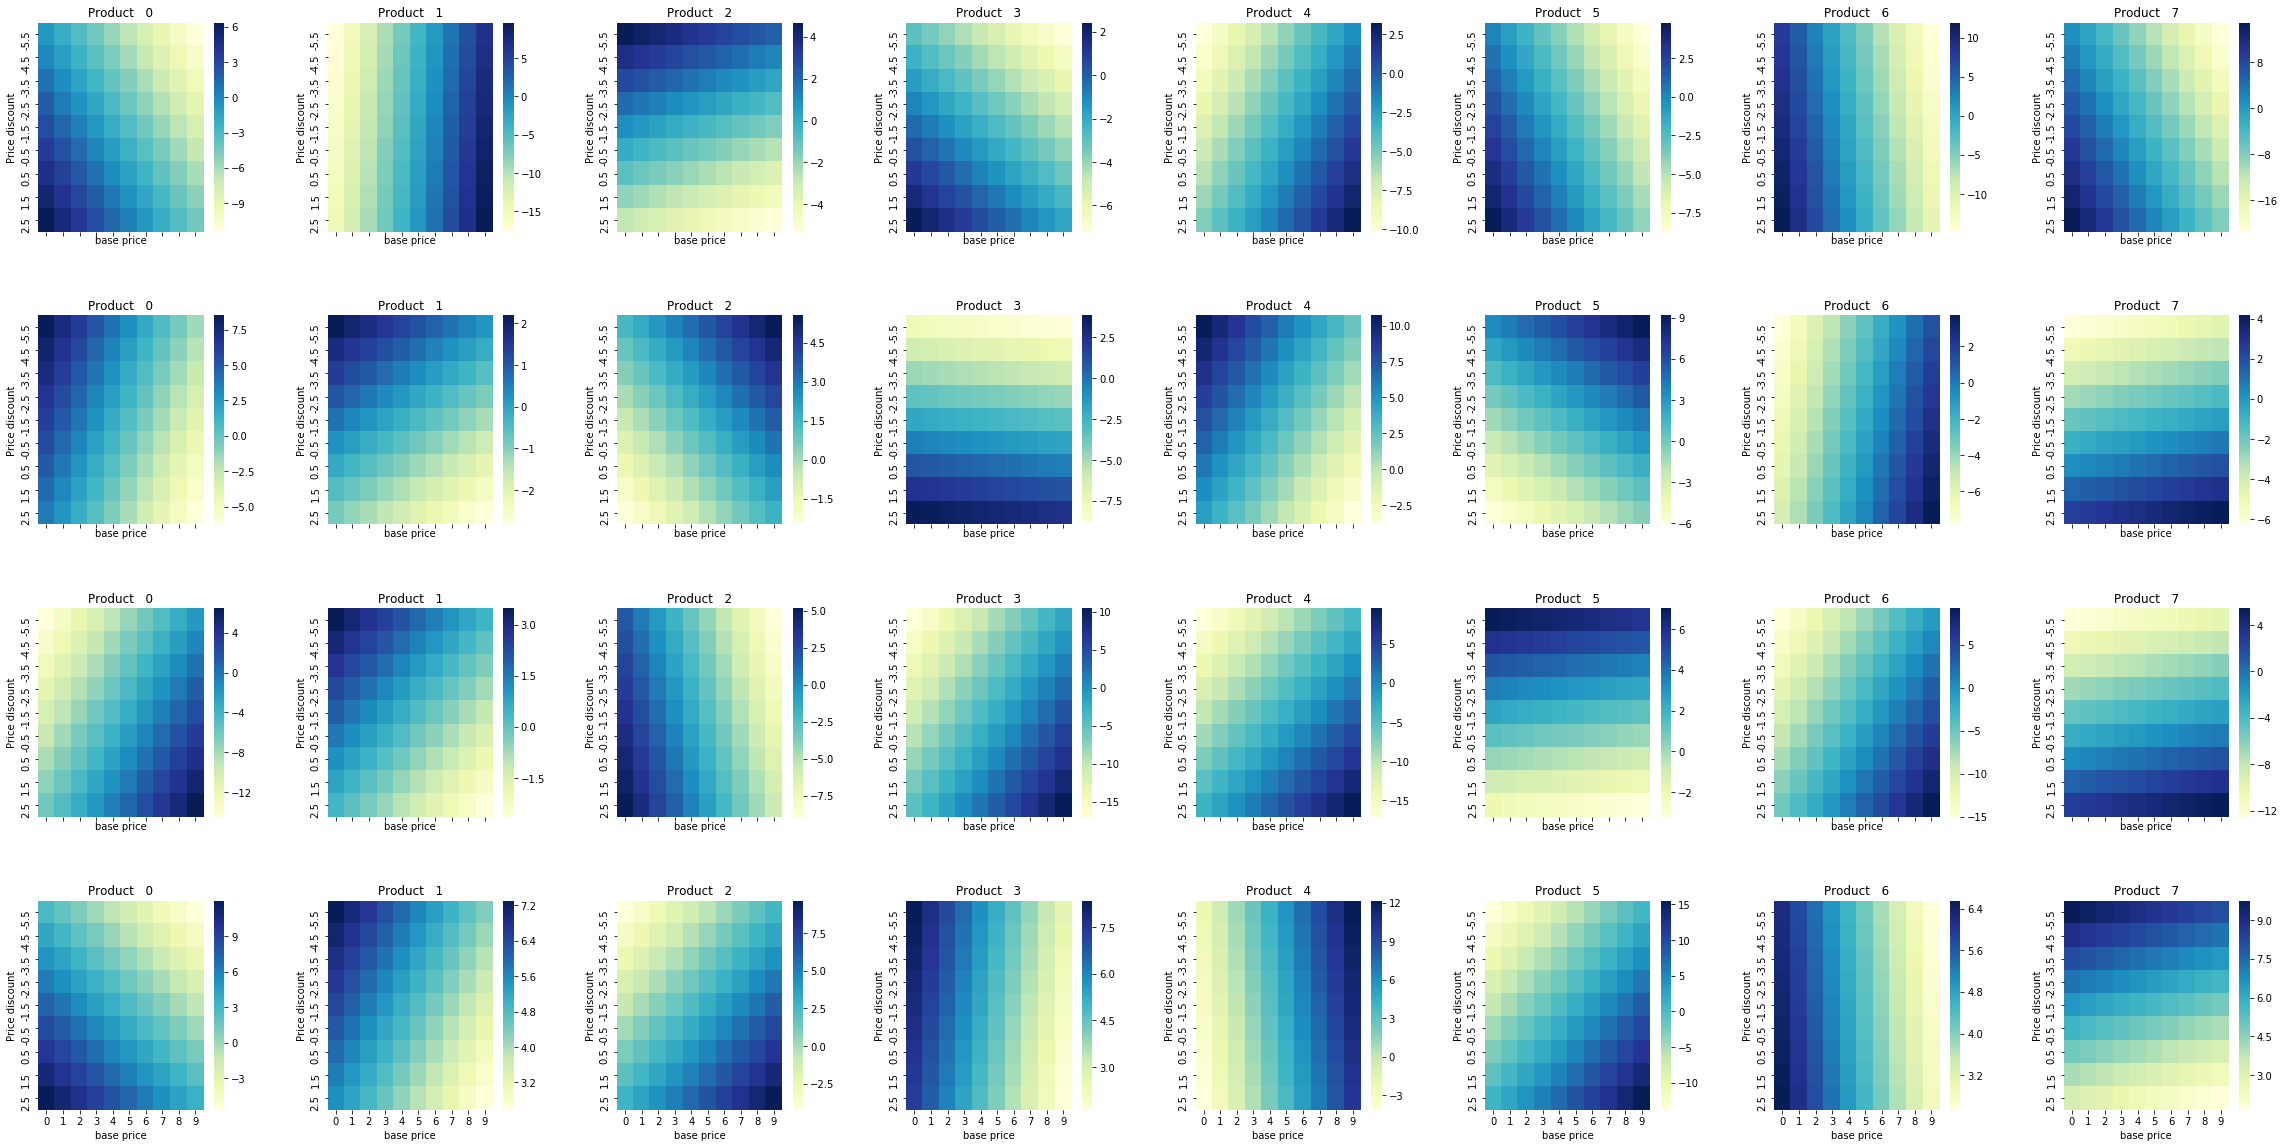

In [32]:
s=[0,1,2,10]
fig, ax = plt.subplots(len(s), fit.data['P'], sharex='col', sharey='col',figsize=(40,20))

for i in range(0,len(s)):
    for p in range(0,fit.data['P']):
        sns.heatmap(fit['pred_matrix'][s[i],p,1,:,:],yticklabels=fit.data['price_discount_pred'],cmap="YlGnBu",ax=ax[i,p],)
        ax[i,p].set_xlabel('base price')
        ax[i,p].set_ylabel('Price discount')
        ax[i,p].set_title(r'Product{:4.0f}'.format(p))
    #sns.heatmap(fit['pred_matrix_select'][s[i],:,:],yticklabels=fit.data['price_pred'],cmap="YlGnBu",ax=ax[i,1])

fig.subplots_adjust(hspace=0.4, wspace=0.4)


A plot showing the different prediction matrices for different products in each row. Each row is a different sample from the prior. The plots are for one position.

Text(0.5, 0, 'positions')

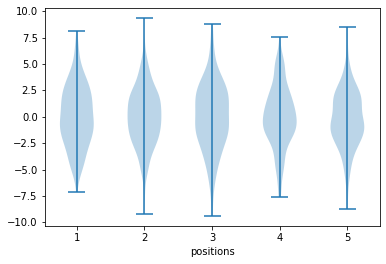

In [33]:
plt.violinplot(fit['hier_c_mean'])
plt.xlabel('positions')

The hierarchical mean values for position

## Fit prior samples

In [36]:
def zscore(posterior, truth):
    return np.abs((np.mean(posterior)-truth)/np.std(posterior))
def shrinkage(posterior,prior):
    return 1-(np.var(posterior)/np.var(prior))

In [37]:
def get_indicators(N, M, prob_std=0.5):
    ind = np.random.binomial(1, prob_std, (N, M))
    return ind>0

In [38]:
x,y=np.meshgrid(fit.data['price_pred'],fit.data['price_discount_pred'])


In [39]:
zscore_prior_pred_c=np.empty((fit.data['P'],fit.data['K'],10))
zscore_prior_pred_m=np.empty((fit.data['P'],2,10))
shrinkage_prior_pred_c=np.empty((fit.data['P'],fit.data['K'],10))
shrinkage_prior_pred_m=np.empty((fit.data['P'],2,10))
zscore_hier_mean=np.empty((fit.data['K'],10))
zscore_hier_sig=np.empty((fit.data['K'],10))
shrinkage_hier_mean=np.empty((fit.data['K'],10))


for s in range(0,10):
    data_prior={
        'K':fit.data['K'],
        'N':fit['pred_matrix'][s,:,:,:].flatten().size, # the use of tile is to get correct indexing
        'price':np.vstack((np.tile(np.tile(x,fit.data['K']),fit.data['P']).flatten(),
                           np.tile(np.tile(x,fit.data['K']),
                                   fit.data['P']).flatten())).T,
        'kk':np.tile(np.repeat(np.arange(1,fit.data['K']+1),x.flatten().size),fit.data['P']),
        'y':fit['pred_matrix_select'][s,:,:,:,:].flatten().astype(int),
        'nprice':10,
        'ndisc':10,
        'price_pred':np.arange(-5,5,1.0),
        'price_discount_pred':np.arange(-5,5,1.0),
        'P':8,
        'product':np.repeat(np.arange(1,fit.data['P']+1),fit.data['K']*x.flatten().size),
        'fit':1
        }
    
    fit_prior=sm.sampling(data=data_prior)
    zscore_prior_pred_c[:,:,s]=zscore(fit_prior['c'],fit['c'][s,:,:])
    for j in range(0,fit.data['P']):
        shrinkage_prior_pred_m[j,:,s]=shrinkage(fit_prior['m'][:,j,:],fit['m'][:,j,:])
        for i in range(0,fit.data['K']):
            shrinkage_prior_pred_c[j,i,s]=shrinkage(fit_prior['c'][:,j,i],fit['c'][:,j,i])
    zscore_prior_pred_m[:,:,s]=zscore(fit_prior['m'],fit['m'][s])
    zscore_hier_mean[:,s]=zscore(fit_prior['hier_c_mean'],fit['hier_c_mean'][s])
    for i in range(0,fit.data['K']):
        shrinkage_hier_mean[i,s]=shrinkage(fit_prior['hier_c_mean'][:,i],fit['hier_c_mean'][:,i])


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


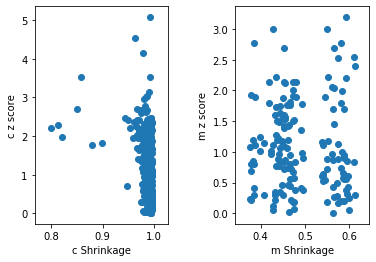

In [41]:
plt.subplot(1,2,1)
plt.scatter(shrinkage_prior_pred_c,zscore_prior_pred_c)
plt.xlabel('c Shrinkage')
plt.ylabel('c z score')
plt.subplot(1,2,2)

plt.scatter(shrinkage_prior_pred_m,zscore_prior_pred_m)
plt.xlabel('m Shrinkage')
plt.ylabel('m z score')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

Text(0, 0.5, 'hier $\\mu$ c z score')

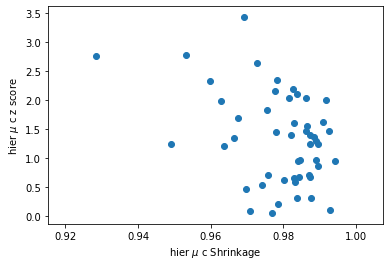

In [42]:
plt.subplot(1,1,1)
plt.scatter(shrinkage_hier_mean,zscore_hier_mean)
plt.xlabel('hier $\mu$ c Shrinkage')
plt.ylabel('hier $\mu$ c z score')
